In [1]:
import os
import requests
import io
import pandas as pd

In [2]:
def descargar_datos():
    # URL para descargar los datos
    csv_url = 'https://citsci-noise-server.ornith.cornell.edu/noise/download/csv?lang=en'
    
    # Realizar la solicitud
    response_csv = requests.get(csv_url)

    # Verificar la respuesta
    if response_csv.status_code == 200:
        csv_content = io.StringIO(response_csv.text)
        df = pd.read_csv(csv_content)
        return df
    else:
        raise Exception("Error al descargar los datos")

In [3]:
def transformar_datos(df):
    # Convertir a datetime
    df['Start date/time in UTC'] = pd.to_datetime(df['Start date/time in UTC'])
    df['Start date UTC'] = df['Start date/time in UTC'].dt.normalize()
    df['Start time UTC'] = df['Start date/time in UTC'].dt.time

    # Cambio en la especificación de la zona horaria
    df['Timezone'] = df['Timezone'].str.replace('America/New_York', 'New York')

    # Filtrado y renombramiento
    df = df[df['Timezone'] == 'New York']
    df = df.rename(columns={'Emoji descriptions':'Noise_Source'})
    df['Mood_scale'] = df['Mood'].apply(lambda Mood: "Extremely Happy" if Mood == 1 else 
                                        "Happy" if Mood == 2 else 
                                        "Neutral" if Mood == 3 else 
                                        "Somewhat Sad" if Mood == 4 else 
                                        "Very Sad" if Mood == 5 else "Unknown")
    df.drop(['Emoji', 'Mood'], axis=1, inplace=True)
    df['Nominated as noise refuge'] = df['Nominated as noise refuge'].fillna(False)

    # Tipo de datos
    df = df.astype({'Duration (s)': int, 'Observer ID': int, 
                    'Latitude': float, 'Longitude': float, 
                    'Mean volume (dBA)': int, 
                    'Could control noise exposure': bool, 
                    'Indoors': bool, 'Nominated as noise refuge': bool})

    # Nuevas columnas de tiempo
    df['timestamp'] = pd.to_datetime(df['Start date/time in UTC'])
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['day_of_week'] = df['timestamp'].dt.dayofweek + 1

    return df


In [4]:
def cargar_datos(df, nombre_archivo='arima.csv'):
    df.to_csv(nombre_archivo, index=False)


In [5]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

def modelo_arima(df_path):
    df = pd.read_csv(df_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    monthly_ts = df['Mean volume (dBA)'].resample('M').mean()
    monthly_ts = monthly_ts[monthly_ts.index < '2024-01-01']
    
    new_date_range = pd.date_range(start=monthly_ts.index[0], end=monthly_ts.index[-1], freq='M')
    monthly_ts_reindexed = monthly_ts.reindex(new_date_range).interpolate()
    monthly_ts_reindexed.index.freq = 'M'
    
    modelo = ARIMA(monthly_ts_reindexed, order=(1, 0, 1))
    modelo_ajustado = modelo.fit()
    n_pasos = 6
    pronostico = modelo_ajustado.get_forecast(steps=n_pasos)
    valores_pronosticados = pronostico.predicted_mean
    serie_pronosticada = pd.Series(valores_pronosticados, index=pronostico.row_labels)

    plt.figure(figsize=(10, 6))
    plt.plot(monthly_ts_reindexed, label='Real')
    plt.plot(serie_pronosticada, label='Pronosticado', color='red')
    plt.xlabel('Mes')
    plt.ylabel('Volumen Promedio (dBA)')
    plt.legend()
    plt.show()

    return serie_pronosticada


Datos descargados con éxito.
Datos transformados con éxito.
Datos cargados con éxito en 'arima.csv'.


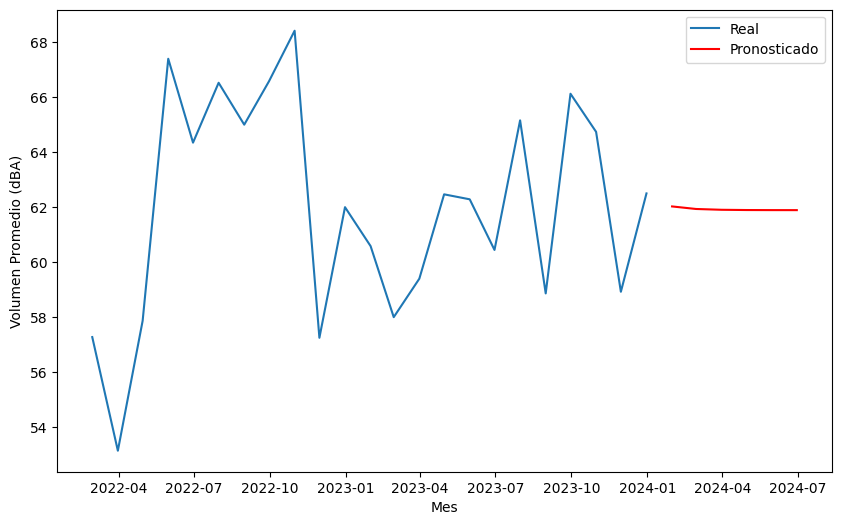

Modelo ARIMA ejecutado con éxito.
2024-01-31    62.026652
2024-02-29    61.934029
2024-03-31    61.904910
2024-04-30    61.895756
2024-05-31    61.892878
2024-06-30    61.891973
Freq: M, Name: predicted_mean, dtype: float64


In [6]:
def main():
    # 1. Extracción
    try:
        datos_crudos = descargar_datos()
        print("Datos descargados con éxito.")
    except Exception as e:
        print(f"Error en la extracción: {e}")
        return

    # 2. Transformación
    try:
        datos_transformados = transformar_datos(datos_crudos)
        print("Datos transformados con éxito.")
    except Exception as e:
        print(f"Error en la transformación: {e}")
        return

    # 3. Carga
    try:
        cargar_datos(datos_transformados, 'arima.csv')
        print("Datos cargados con éxito en 'arima.csv'.")
    except Exception as e:
        print(f"Error en la carga: {e}")
        return

    # 4. Ejecución del modelo ARIMA
    try:
        serie_pronosticada = modelo_arima('arima.csv')
        print("Modelo ARIMA ejecutado con éxito.")
        print(serie_pronosticada)
    except Exception as e:
        print(f"Error en el modelo ARIMA: {e}")
        return

# Llamar al método principal
if __name__ == "__main__":
    main()